<a href="https://colab.research.google.com/github/ehddnr301/dacon_cv2/blob/master/dacon_computervision2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Tue Feb  9 06:24:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os

os.listdir('/content/drive/MyDrive/dacon_computer_vision/')

['data',
 'Untitled1.ipynb',
 'model.h5',
 'eff_model.pt',
 'eff_model1.pt',
 'dacon-vision2.ipynb',
 'Untitled0.ipynb',
 'checkpoint',
 'dacon_cv.zip',
 'eff_model_cv2.pt',
 'dacon_cv2.ipynb',
 'Untitled3.ipynb',
 'Untitled2.ipynb',
 'dacon_computervision2.ipynb']

In [4]:
# !unzip -n '/content/drive/MyDrive/dacon_computer_vision/dacon_cv.zip' -d '/content/drive/MyDrive/dacon_computer_vision/data/'

In [5]:
# colab 에서 자꾸 unzip한 이미지중에 일부가 없어져서 -n modifier를 주고 계속 실행하려함.
!unzip -n '/content/drive/MyDrive/dacon_computer_vision/data/dirty_mnist_2nd.zip' -d '/content/drive/MyDrive/dacon_computer_vision/data/dirty_mnist'

Archive:  /content/drive/MyDrive/dacon_computer_vision/data/dirty_mnist_2nd.zip
error:  cannot create /content/drive/MyDrive/dacon_computer_vision/data/dirty_mnist/00000.png
        Input/output error
/content/drive/MyDrive/dacon_computer_vision/data/dirty_mnist/00001.png exists and is a symbolic link with no real file.


In [6]:
!pip install torchinfo

In [7]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16032 sha256=ec5db78d8af2b03536dd72a4d341fd637c070fe0c760f9621fadb5eaa384af1c
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [8]:
from efficientnet_pytorch import EfficientNet

In [9]:
import os
from typing import Tuple, Sequence, Callable
import csv
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torch.optim as optim
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchinfo import summary

from torchvision import transforms


In [10]:
# random seed
random_seed = 121
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)


IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
EPOCHS=40

PATH_TRAIN_DATASET='/content/drive/MyDrive/dacon_computer_vision/data/dirty_mnist/'
PATH_TEST_DATASET='/content/drive/MyDrive/dacon_computer_vision/data/test_dirty_mnist/'
PATH_TRAIN_ANS_CSV='/content/drive/MyDrive/dacon_computer_vision/data/dirty_mnist_2nd_answer.csv'

In [11]:
df = pd.read_csv(PATH_TRAIN_ANS_CSV)
df.head()

,index,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
0,0,1,1,0,1,0,1,0,0,0,0,1,1,0,0,1,1,0,1,1,0,1,0,0,1,1,1
1,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,1
2,2,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,1,1,0,1,1,1,0
3,3,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0,1,1,0,1,1,0,1,0
4,4,0,1,0,1,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0


In [12]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df, test_size=0.1, random_state=random_seed)

In [13]:
train.head()

,index,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
8891,8891,0,1,0,0,1,0,0,1,1,1,1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1
47123,47123,0,0,1,1,0,0,0,1,0,0,1,1,0,1,1,0,1,0,0,0,1,1,1,1,1,1
1287,1287,0,0,0,1,0,1,1,1,0,0,1,0,1,1,0,0,1,1,0,0,0,1,1,1,1,1
27103,27103,0,0,0,1,1,1,1,0,0,1,1,0,0,1,0,1,1,0,0,0,0,0,1,0,1,1
41974,41974,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,1,1,1,1,0,0


In [14]:
PATH_TRAIN_CSV='/content/drive/MyDrive/dacon_computer_vision/data/mnist_train.csv'
PATH_VALID_CSV='/content/drive/MyDrive/dacon_computer_vision/data/mnist_valid.csv'


In [15]:
train.to_csv(PATH_TRAIN_CSV, index=False)

In [16]:
valid.to_csv(PATH_VALID_CSV, index=False)

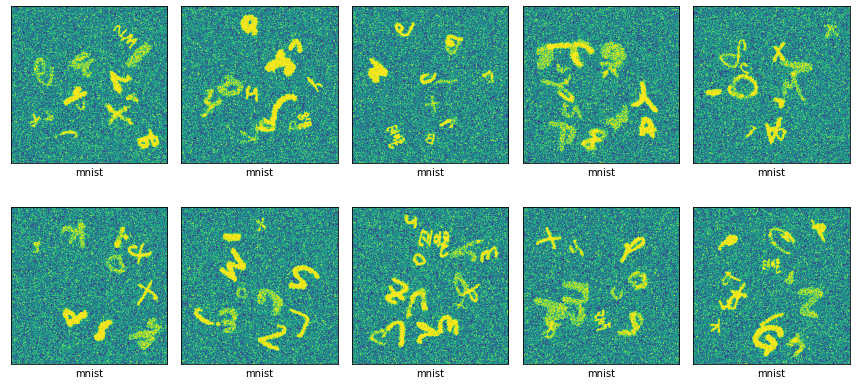

In [17]:
import random
import matplotlib.pyplot as plt


plt.figure(figsize=(12,6))
mnist_sample = random.sample(os.listdir(PATH_TRAIN_DATASET), 10)

for i, image in enumerate(mnist_sample):
  path = os.path.join(PATH_TRAIN_DATASET, image)
  img = Image.open(path)
  plt.subplot(2,5,i+1)
  plt.imshow(img)
  plt.xlabel('mnist')
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()


In [18]:
class MnistDataset(Dataset):
    def __init__(
        self,
        dir: os.PathLike,
        image_ids: os.PathLike,
        transforms: Sequence[Callable]
    ) -> None:
        self.dir = dir
        self.transforms = transforms

        self.labels = {}
        with open(image_ids, 'r') as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                self.labels[int(row[0])] = list(map(int, row[1:]))

        self.image_ids = list(self.labels.keys())

    def __len__(self) -> int:
        return len(self.image_ids)

    def __getitem__(self, index: int) -> Tuple[Tensor]:
        image_id = self.image_ids[index]
        image = Image.open(
            os.path.join(
                self.dir, f'{str(image_id).zfill(5)}.png')).convert('RGB')
        target = np.array(self.labels.get(image_id)).astype(np.float32)

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

In [19]:
transforms_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(180, 180)),
    transforms.RandomAffine(10),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

transforms_valid = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

In [20]:
trainset = MnistDataset(PATH_TRAIN_DATASET, PATH_TRAIN_CSV, transforms_train)
valset = MnistDataset(PATH_TRAIN_DATASET, PATH_VALID_CSV, transforms_valid)
testset = MnistDataset(PATH_TEST_DATASET, '/content/drive/MyDrive/dacon_computer_vision/data/sample_submission.csv', transforms_test)

# train_set, val_set = random_split(trainset, [int(len(trainset)*0.8),int(len(trainset)*0.2)], generator=torch.Generator().manual_seed(random_seed))
# train_set, val_set = random_split(trainset, [int(len(trainset)*0.95),int(len(trainset)*0.05)], generator=torch.Generator().manual_seed(random_seed))

train_loader = DataLoader(trainset, batch_size=16)
val_loader = DataLoader(valset, batch_size=32)
test_loader = DataLoader(testset, batch_size=8)

In [21]:
print(valset.labels)

{48023: [1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1], 2885: [1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0], 31378: [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0], 12366: [0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0], 34618: [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0], 28398: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0], 47963: [1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1], 47451: [1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0], 44483: [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0], 39181: [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1], 6536: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0], 22469: [1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 

In [22]:
class MnistModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.effnet = EfficientNet.from_pretrained('efficientnet-b7')
        self.classifier = nn.Linear(1000, 26)

    def forward(self, x):
        x = self.effnet(x)
        x = self.classifier(x)

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MnistModel().to(device)
print(summary(model, input_size=(1, 3, 256, 256), verbose=0))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth



Loaded pretrained weights for efficientnet-b7
Layer (type:depth-idx)                                  Output Shape              Param #
├─EfficientNet: 1-1                                     [1, 1000]                 --
|    └─Conv2dStaticSamePadding: 2-1                     [1, 64, 128, 128]         --
|    |    └─ZeroPad2d: 3-1                              [1, 3, 258, 258]          --
|    └─BatchNorm2d: 2-2                                 [1, 64, 128, 128]         128
|    └─MemoryEfficientSwish: 2-3                        [1, 64, 128, 128]         --
|    └─ModuleList: 2                                    []                        --
|    |    └─MBConvBlock: 3-2                            [1, 32, 128, 128]         4,944
|    |    └─MBConvBlock: 3-3                            [1, 32, 128, 128]         1,992
|    |    └─MBConvBlock: 3-4                            [1, 32, 128, 128]         1,992
|    |    └─MBConvBlock: 3-5                            [1, 32, 128, 128]         1,992


In [23]:
# from sklearn.model_selection import KFold

# kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed)

# best_models = []

# for fold_index, (train_index, val_index) in enumerate(kfold.split(train_loader)):


In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.MultiLabelSoftMarginLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                  mode='min',
                                                  factor=0.5,
                                                  patience=2,)



for epoch in range(EPOCHS):
    
    model.train()

    for i, (images, targets) in enumerate(train_loader):
        optimizer.zero_grad()

        images = images.to(device)
        targets = targets.to(device)

        with torch.set_grad_enabled(True):
            outputs = model(images)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

        if i % 50 == 0:
            outputs = outputs > 0.5
            acc = (outputs == targets).float().mean()
            print(f'{epoch+1}: {loss.item():.5f}, {acc.item():.5f}')

    model.eval()

    valid_acc_list = []
    with tqdm(val_loader,
            total=val_loader.__len__(),
            unit="batch") as valid_bar:
        for i, (images, targets) in enumerate(valid_bar):
            valid_bar.set_description(f"Valid Epoch {epoch + 1}")
            optimizer.zero_grad()

            images = images.to(device)
            targets = targets.to(device)

            # 모델의 dropoupt, batchnormalization를 eval모드로 설정
            # .forward()에서 중간 노드의 gradient를 계산
            with torch.no_grad():
                # validation loss만을 계산
                probs  = model(images)
                valid_loss = criterion(probs, targets)

                scheduler.step(valid_loss)

                # train accuracy 계산
                probs  = probs.cpu().detach().numpy()
                targets = targets.cpu().detach().numpy()
                preds = probs > 0.5
                batch_acc = (targets == preds).mean()
                valid_acc_list.append(batch_acc)

            valid_acc = np.mean(valid_acc_list)
            valid_bar.set_postfix(valid_loss = valid_loss.item(),
                                  valid_acc = valid_acc)


    if (epoch + 1) % 5 == 0:
        torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, f'/content/drive/MyDrive/dacon_computer_vision/checkpoint/model{epoch + 1}.pt')
    
    print('------------------')

1: 0.70281, 0.53125
1: 0.70179, 0.54567
1: 0.69430, 0.54327
1: 0.69895, 0.52644
1: 0.68521, 0.55529
1: 0.66599, 0.56731
1: 0.68339, 0.52885
1: 0.67116, 0.55769
1: 0.69194, 0.53846
1: 0.68694, 0.56010
1: 0.67162, 0.56971
1: 0.66794, 0.56010
1: 0.66570, 0.56490
1: 0.66889, 0.56731
1: 0.68521, 0.53846
1: 0.67497, 0.55769
1: 0.67642, 0.55288
1: 0.68966, 0.54087
1: 0.68095, 0.57452
1: 0.67178, 0.59615
1: 0.66190, 0.59856
1: 0.67315, 0.56490
1: 0.65427, 0.58413
1: 0.65601, 0.59135
1: 0.65558, 0.58413
1: 0.68681, 0.54567
1: 0.65607, 0.56971
1: 0.66471, 0.56971


In [ ]:
torch.save(model, '/content/drive/MyDrive/dacon_computer_vision/eff_model_0208.pt')

In [ ]:
!unzip -n '/content/drive/MyDrive/dacon_computer_vision/data/test_dirty_mnist_2nd.zip' -d '/content/drive/MyDrive/dacon_computer_vision/data/test_dirty_mnist'

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dacon_computer_vision/data/sample_submission.csv')

model.eval()
batch_size = test_loader.batch_size
batch_index = 0
for i, (images, targets) in enumerate(test_loader):
    images = images.to(device)
    targets = targets.to(device)
    outputs = model(images)
    outputs = outputs > 0.5
    batch_index = i * batch_size
    submit.iloc[batch_index:batch_index+batch_size, 1:] = \
        outputs.long().squeeze(0).detach().cpu().numpy()
    
submit.to_csv('/content/drive/MyDrive/dacon_computer_vision/data/submit0208.csv', index=False)